In [151]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-hack-pfo/train_data/sample_submission.csv
/kaggle/input/ai-hack-pfo/train_data/trnsctns_ops_trn.csv
/kaggle/input/ai-hack-pfo/train_data/readme.md
/kaggle/input/ai-hack-pfo/train_data/cntrbtrs_clnts_ops_trn.csv
/kaggle/input/ai-hack-pfo/train_data/dst_dscrptn.docx
/kaggle/input/postal-code-to-geo/pstl_code_to_geo.csv


In [3]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

sns.set_theme()

In [66]:
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor

import shap

shap.initjs()

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Load data and print info

## Geo info

In [154]:
df_geo = pd.read_csv('/kaggle/input/postal-code-to-geo/pstl_code_to_geo.csv', index_col='Unnamed: 0')
df_geo.head()

,place_name,state_name,state_code,latitude,longitude
352634,Белореченск 4,Краснодарский Край,38.0,44.7600,39.8700
353235,Афипский,Краснодарский Край,38.0,44.9000,38.8400
404101,Волжский 1,Волгоградская Область,84.0,48.7906,44.7717
610040,Киров 40,Кировская Область,33.0,56.6118,44.0550
625001,Тюмень 1,Тюменская Область,78.0,57.1522,65.5272


In [155]:
df_geo['pstl_code'] = df_geo.index

## Client info

In [455]:
df_cnt = pd.read_csv('/kaggle/input/ai-hack-pfo/train_data/cntrbtrs_clnts_ops_trn.csv', encoding='cp1251', sep=';')
df_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532825 entries, 0 to 532824
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   slctn_nmbr      532825 non-null  int64  
 1   clnt_id         532825 non-null  object 
 2   accnt_id        532825 non-null  object 
 3   gndr            532825 non-null  object 
 4   brth_yr         532825 non-null  int64  
 5   prsnt_age       532825 non-null  int64  
 6   accnt_bgn_date  532825 non-null  object 
 7   cprtn_prd_d     532825 non-null  int64  
 8   erly_pnsn_flg   532825 non-null  int64  
 9   accnt_status    532825 non-null  object 
 10  pnsn_age        532825 non-null  int64  
 11  prvs_npf        469411 non-null  object 
 12  brth_plc        532825 non-null  object 
 13  addrss_type     532825 non-null  object 
 14  rgn             532133 non-null  object 
 15  dstrct          200421 non-null  object 
 16  city            378555 non-null  object 
 17  sttlmnt   

In [456]:
df_cnt.head()

,slctn_nmbr,clnt_id,accnt_id,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,erly_pnsn_flg,accnt_status,...,dstrct,city,sttlmnt,pstl_code,okato,phn,email,lk,assgn_npo,assgn_ops
0,0,0x03ED62E56DAEA24B96D6F1252D713286,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,ж,1960,64,2005-12-21,96,0,Накопительный период,...,NaN,ОМСК Г,NaN,644001,5.200000e+10,нет,нет,нет,нет,нет
1,0,0x15138C4A822F1C45A819FCBE6657B810,0x222F5E5BA3715F418662A3C65B0B051F,м,1954,70,2009-06-29,283,0,Накопительный период,...,NaN,БЕЛОГОРСК Г,NaN,676852,1.000000e+10,нет,нет,нет,нет,нет
2,3,0x943D2C768A4FB38311E659ACF7E960C3,0x943D2C768A4FB38311E659ACF7E960C5,м,1955,69,2006-12-25,88,0,Накопительный период,...,NaN,NaN,NaN,109451,4.500000e+10,нет,нет,нет,нет,нет
3,2,0x9CAE18EC4F30054C83C6C78FF70D124A,0xB7BAA18DCFE2E842A7AF84BBE185265C,ж,1962,62,2013-09-03,1301,0,Накопительный период,...,АЛЬМЕТЬЕВСКИЙ Р-Н,АЛЬМЕТЬЕВСК Г,NaN,423464,9.200000e+10,нет,нет,нет,нет,нет
4,2,0xCB416F5FE5D58E41822B4E9A5209747F,0x68D14914CF3A79408F6A6E097C1A61AF,м,1955,69,2010-12-06,106,0,Накопительный период,...,ВОТКИНСКИЙ Р-Н,NaN,МОЛЧАНЫ Д,427415,9.400000e+10,нет,нет,нет,нет,нет


In [457]:
df_cnt.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
slctn_nmbr,532825.0,NaN,NaN,NaN,0.830727,1.142931,0.0,0.0,0.0,2.0,3.0
clnt_id,532825,532825,0x03ED62E56DAEA24B96D6F1252D713286,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accnt_id,532825,532825,0xFFB14DE2D28AAD45B08AC54ADDFE6AD2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gndr,532825,2,ж,343320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brth_yr,532825.0,NaN,NaN,NaN,1959.857501,3.693279,1925.0,1958.0,1960.0,1962.0,1987.0
prsnt_age,532825.0,NaN,NaN,NaN,64.142499,3.693279,37.0,62.0,64.0,66.0,99.0
accnt_bgn_date,532825,4070,2004-09-30,6070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cprtn_prd_d,532825.0,NaN,NaN,NaN,324.073215,581.011155,0.0,108.0,182.0,326.0,7269.0
erly_pnsn_flg,532825.0,NaN,NaN,NaN,0.036367,0.187201,0.0,0.0,0.0,0.0,1.0
accnt_status,532825,2,Накопительный период,511517,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [458]:
def print_col_info(df):
    uniq_col_count = []
    for col in df:
        uniq_count = df[col].unique()
        types = set([type(x) for x in uniq_count])
        uniq_col_count.append([col, len(uniq_count), uniq_count[:10], types])

    uniq_col_count.sort(key=lambda x: x[1])

    print(tabulate(uniq_col_count, headers=['Col', 'Uniq_num', 'Values (top 10)', 'Types']))
    
print_col_info(df_cnt)

Col               Uniq_num  Values (top 10)                                                              Types
--------------  ----------  ---------------------------------------------------------------------------  --------------------------------
gndr                     2  ['ж' 'м']                                                                    {<class 'str'>}
erly_pnsn_flg            2  [0 1]                                                                        {<class 'numpy.int64'>}
accnt_status             2  ['Накопительный период' 'Выплатной период']                                  {<class 'str'>}
phn                      2  ['нет' 'да']                                                                 {<class 'str'>}
email                    2  ['нет' 'да']                                                                 {<class 'str'>}
lk                       2  ['нет' 'да']                                                                 {<class 'str'>}
assgn_npo        

In [459]:
def print_null(df):
    cols_with_missing = [col for col in df.columns
                         if df[col].isnull().any()]

    col_null_count = []
    for col in cols_with_missing:
        null_count = df[col].isnull().sum()
        col_null_count.append([
            col, 
            null_count,
            round(null_count / len(df[col]), 2),
            df[col].dtype
        ])

    col_null_count.sort(key=lambda x: x[1])
    
    print(tabulate(col_null_count, headers=['Col', 'Null Count', 'Null %', 'Type']))

print_null(df_cnt)

Col         Null Count    Null %  Type
--------  ------------  --------  -------
rgn                692      0     object
okato              692      0     float64
prvs_npf         63414      0.12  object
city            154270      0.29  object
dstrct          332404      0.62  object
sttlmnt         373226      0.7   object


slctn_nmbr - номер выбоки

clnt_id - дропаем, тк повторяет accnt_id

accnt_id - оставляем 

gndr - оставляем

brth_yr - оставляем

prsnt_age - можно оставить, тк это на текущий год.

accnt_bgn_date - оставляем, это договор с фирмой о пенсии.

cprtn_prd_d - дропаем, тк вопрос о будущем.

erly_pnsn_flg - оставляем

accnt_status - дропаем, тк выплаты могут идти только пенсионерам, значит уже не ставится задача предсказанию выхода на пенсию.

pnsn_age - дропаем, тк не можем предсказать действия государства.

prvs_npf - оставляем

brth_plc - оставляем

addrss_type - оставляем

rgn - оставляем

dstrct - оставляем

city - оставляем 

sttlmnt - оставляем

pstl_code - оставляем

okato - оставляем

phn - оставляем

email - оставляем

lk - оставляем

assgn_npo - оставляем

assgn_ops - оставляем

In [460]:
# преобразование типов
df_cnt['accnt_bgn_date'] = pd.to_datetime(df_cnt['accnt_bgn_date'])
df_cnt['first_pens_date'] = df_cnt['accnt_bgn_date'] + pd.to_timedelta(df_cnt['cprtn_prd_d'], unit='D')
df_cnt['current_date'] = pd.to_datetime(df_cnt['brth_yr'], format='%Y') + pd.to_timedelta(df_cnt['prsnt_age'], unit='D') * 365
df_cnt['off_pens_date'] = pd.to_datetime(df_cnt['brth_yr'], format='%Y') + pd.to_timedelta(df_cnt['pnsn_age'], unit='D') * 365
df_cnt['pstl_code'] = pd.to_numeric(df_cnt['pstl_code'], errors='coerce')

# clnt_id имеет такойже смысл как и accnt_id
cols_for_drop = ['clnt_id']
df_cnt = df_cnt.drop(columns=cols_for_drop)

# фичи, в которых много пропущенных значений
cols_for_drop = ['dstrct', 'sttlmnt']
df_cnt = df_cnt.drop(columns=cols_for_drop)

In [461]:
print_null(df_cnt)

Col          Null Count    Null %  Type
---------  ------------  --------  -------
pstl_code             1      0     float64
rgn                 692      0     object
okato               692      0     float64
prvs_npf          63414      0.12  object
city             154270      0.29  object


In [462]:
# заполним пропущенные значения у числовых признаков
df_cnt['okato'] = df_cnt['okato'].fillna(0)
df_cnt['pstl_code'] = df_cnt['pstl_code'].fillna(0)

df_cnt = df_cnt.dropna(subset=['pstl_code'])
df_cnt['prvs_npf'] = df_cnt['prvs_npf'].fillna(df_cnt['prvs_npf'].value_counts()[0])
df_cnt['rgn'] = df_cnt['rgn'].fillna('nan')
df_cnt['city'] = df_cnt['city'].fillna('nan')

In [187]:
df_geo.columns

Index(['place_name', 'state_name', 'state_code', 'latitude', 'longitude',
       'pstl_code'],
      dtype='object')

In [188]:
df_cnt.columns

Index(['slctn_nmbr', 'accnt_id', 'gndr', 'brth_yr', 'prsnt_age',
       'accnt_bgn_date', 'cprtn_prd_d', 'erly_pnsn_flg', 'accnt_status',
       'pnsn_age', 'prvs_npf', 'brth_plc', 'addrss_type', 'rgn', 'city',
       'pstl_code', 'okato', 'phn', 'email', 'lk', 'assgn_npo', 'assgn_ops',
       'first_pens_date', 'current_date', 'off_pens_date'],
      dtype='object')

In [218]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36802 entries, 352634 to 452657
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   place_name  36802 non-null  object 
 1   state_name  36730 non-null  object 
 2   state_code  36096 non-null  float64
 3   latitude    36802 non-null  float64
 4   longitude   36802 non-null  float64
 5   pstl_code   36802 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB


In [463]:
df_cnt['pstl_code'] = df_cnt['pstl_code'].astype(int)
df_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532825 entries, 0 to 532824
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   slctn_nmbr       532825 non-null  int64         
 1   accnt_id         532825 non-null  object        
 2   gndr             532825 non-null  object        
 3   brth_yr          532825 non-null  int64         
 4   prsnt_age        532825 non-null  int64         
 5   accnt_bgn_date   532825 non-null  datetime64[ns]
 6   cprtn_prd_d      532825 non-null  int64         
 7   erly_pnsn_flg    532825 non-null  int64         
 8   accnt_status     532825 non-null  object        
 9   pnsn_age         532825 non-null  int64         
 10  prvs_npf         532825 non-null  object        
 11  brth_plc         532825 non-null  object        
 12  addrss_type      532825 non-null  object        
 13  rgn              532825 non-null  object        
 14  city             532

In [464]:
df_cnt = df_cnt.merge(df_geo, on='pstl_code', how='inner')
df_cnt = df_cnt.groupby('accnt_id').first()

In [465]:
df_cnt

,slctn_nmbr,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,erly_pnsn_flg,accnt_status,pnsn_age,prvs_npf,...,assgn_npo,assgn_ops,first_pens_date,current_date,off_pens_date,place_name,state_name,state_code,latitude,longitude
accnt_id,,,,,,,,,,,,,,,,,,,,,
0x00003A37F46E104EB1AB513510DC1C79,1,ж,1962,62,2011-02-25,397,0,Накопительный период,55,СФР,...,нет,нет,2012-03-28,2023-12-17,2016-12-18,Мыски,Кемеровская Область,29.0,53.7000,87.8000
0x00005C5B81A6B34C93DD254536771BB6,0,м,1959,65,2008-11-28,123,0,Накопительный период,60,СФР,...,нет,нет,2009-03-31,2023-12-16,2018-12-17,Мурманск 38,Мурманская Область,49.0,68.9717,33.0819
0x000068BD0A374844BBD3F76E903BF0EE,0,ж,1962,62,2011-10-28,152,0,Накопительный период,55,СФР,...,нет,нет,2012-03-28,2023-12-17,2016-12-18,Октябрьск,Самарская Область,65.0,55.2628,102.2481
0x0000DEB99BDBE74D8298A7772971F4E5,0,м,1956,68,2006-12-26,87,0,Накопительный период,60,СФР,...,нет,нет,2007-03-23,2023-12-15,2015-12-17,Казань 78,Татарстан Республика,73.0,55.7500,49.1333
0x0000E3BFC6067F40844C2776DC44C5D9,0,ж,1963,61,2012-08-24,214,0,Накопительный период,55,СФР,...,нет,нет,2013-03-26,2023-12-17,2017-12-18,Челябинск 71,Челябинская Область,13.0,55.1544,61.4297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xFFFF62444E711C46A1F960FCFF343C6C,0,ж,1957,67,2010-11-02,140,0,Накопительный период,55,СФР,...,нет,нет,2011-03-22,2023-12-16,2011-12-19,Елец,Липецкая Область,43.0,52.6133,38.5203
0xFFFF963DF681954095E4497060A5FB49,0,ж,1964,60,2010-10-25,140,0,Накопительный период,55,СФР,...,нет,нет,2011-03-14,2023-12-17,2018-12-18,Лиман,Астраханская Область,7.0,45.7850,47.2303
0xFFFFFCA6FFA8F54C96D02BB60C0BDBAE,1,ж,1964,60,2013-03-20,121,0,Накопительный период,55,СФР,...,нет,нет,2013-07-19,2023-12-17,2018-12-18,Кодинск 1,Красноярский Край,91.0,58.3292,99.1890


In [466]:
df_cnt = df_cnt.drop(columns=['place_name', 'state_name', 'pstl_code', 'brth_plc', 'rgn', 'city'])

<Axes: xlabel='brth_yr', ylabel='Count'>

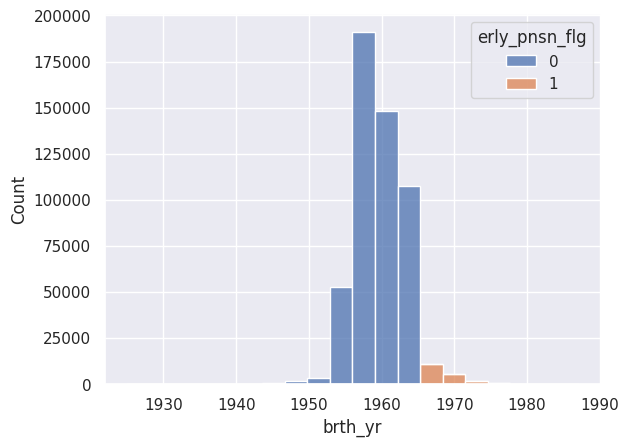

In [467]:
sns.histplot(df_cnt, x='brth_yr', hue='erly_pnsn_flg', multiple='stack', bins=20)

## Transaction info

In [506]:
df_trn = pd.read_csv('/kaggle/input/ai-hack-pfo/train_data/trnsctns_ops_trn.csv', encoding='cp1251', sep=';')
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27225905 entries, 0 to 27225904
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   accnt_id    object 
 1   mvmnt_type  float64
 2   sum_type    object 
 3   cmmnt       object 
 4   sum         float64
 5   oprtn_date  object 
dtypes: float64(2), object(4)
memory usage: 1.2+ GB


In [507]:
df_trn.head()

,accnt_id,mvmnt_type,sum_type,cmmnt,sum,oprtn_date
0,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,2096.31,2012-02-12
1,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-02-13
2,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-05-15
3,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-08-14
4,0x00003A37F46E104EB1AB513510DC1C79,0.0,Страховые взносы на НЧ,Поступление взносов ОПС,0.00,2012-11-13


In [508]:
df_trn.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
accnt_id,27225905,532825,0x943D2C768A4FB38311E658CDB27D09D5,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mvmnt_type,27225905.0,NaN,NaN,NaN,0.106732,0.308772,0.0,0.0,0.0,0.0,1.0
sum_type,27225905,15,ИД на страховые взносы на НЧ,13337957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cmmnt,27225905,15,Распределение ИД ОПС,10995390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,27225905.0,NaN,NaN,NaN,878.55498,5302.398008,-290618.47,0.0,0.3,316.68,849344.48
oprtn_date,27225905,3355,2013-11-11,881533,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [509]:
print_col_info(df_trn)

Col           Uniq_num  Values (top 10)                                                              Types
----------  ----------  ---------------------------------------------------------------------------  -------------------------
mvmnt_type           2  [0. 1.]                                                                      {<class 'numpy.float64'>}
sum_type            15  ['Страховые взносы на НЧ' 'ИД на страховые взносы на НЧ'                     {<class 'str'>}
                         'Доп. страховые взносы (ДСВ1)' 'Взносы софинансирование'
                         'ИД на софинансирование' 'ИД на доп. взносы (ИД ДСВ1)'
                         'ИД на материнский капитал' 'Материнский капитал' 'Выплатной резерв НЧ'
                         'ИД Выплатной резерв НЧ']
cmmnt               15  ['Поступление взносов ОПС' 'Распределение ИД ОПС'                            {<class 'str'>}
                         'Корректировка записей регистров (ОПС)'
                         'Реше

In [510]:
print_null(df_trn)

Col    Null Count    Null %    Type
-----  ------------  --------  ------


In [511]:
# преобразование типов
df_trn['oprtn_date'] = pd.to_datetime(df_trn['oprtn_date'])

In [514]:
%%time
df_trn = df_trn.join(df_cnt[['off_pens_date']], on='accnt_id', validate='m:1')
df_trn['is_valid'] = df_trn['oprtn_date'] < df_trn['off_pens_date']
df_trn['is_valid'] = df_trn['is_valid'].astype(int)

CPU times: user 11.6 s, sys: 2.25 s, total: 13.9 s
Wall time: 13.8 s


In [515]:
%%time
df_trn.describe(include='all').T

CPU times: user 26.8 s, sys: 809 ms, total: 27.6 s
Wall time: 27.4 s


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
accnt_id,27225905,532825,0x943D2C768A4FB38311E658CDB27D09D5,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mvmnt_type,27225905.0,NaN,NaN,NaN,0.106732,0.0,0.0,0.0,0.0,1.0,0.308772
sum_type,27225905,15,ИД на страховые взносы на НЧ,13337957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cmmnt,27225905,15,Распределение ИД ОПС,10995390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,27225905.0,NaN,NaN,NaN,878.55498,-290618.47,0.0,0.3,316.68,849344.48,5302.398008
oprtn_date,27225905,NaN,NaN,NaN,2015-05-04 05:14:50.042609664,1999-11-17 00:00:00,2012-08-13 00:00:00,2014-04-24 00:00:00,2018-08-29 00:00:00,2024-08-11 00:00:00,NaN
off_pens_date,26760506,NaN,NaN,NaN,2016-11-10 11:22:07.006204416,1979-12-19 00:00:00,2013-12-18 00:00:00,2016-12-17 00:00:00,2018-12-17 00:00:00,2051-12-16 00:00:00,NaN
is_valid,27225905.0,NaN,NaN,NaN,0.58345,0.0,0.0,1.0,1.0,1.0,0.492987


In [516]:
df_trn = df_trn[df_trn['is_valid'] == 1]
df_trn = df_trn.drop(columns=['is_valid'])

In [517]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15884944 entries, 0 to 27225882
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   accnt_id       object        
 1   mvmnt_type     float64       
 2   sum_type       object        
 3   cmmnt          object        
 4   sum            float64       
 5   oprtn_date     datetime64[ns]
 6   off_pens_date  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 969.5+ MB


In [518]:
ordinal_encoders = {}
for column in tqdm(['sum_type', 'cmmnt']):
    oe = OrdinalEncoder(encoded_missing_value=-1)
    df_trn[column] = df_trn[column].astype(str)
    df_trn[column] = oe.fit_transform(df_trn[[column]])
    ordinal_encoders[column] = oe

100%|██████████| 2/2 [00:13<00:00,  6.98s/it]


# Cold Start

In [226]:
df_cnt

,slctn_nmbr,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,erly_pnsn_flg,accnt_status,pnsn_age,prvs_npf,...,email,lk,assgn_npo,assgn_ops,first_pens_date,current_date,off_pens_date,state_code,latitude,longitude
accnt_id,,,,,,,,,,,,,,,,,,,,,
0x00003A37F46E104EB1AB513510DC1C79,1,ж,1962,62,2011-02-25,397,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2012-03-28,2023-12-17,2016-12-18,29.0,53.7000,87.8000
0x00005C5B81A6B34C93DD254536771BB6,0,м,1959,65,2008-11-28,123,0,Накопительный период,60,СФР,...,нет,да,нет,нет,2009-03-31,2023-12-16,2018-12-17,49.0,68.9717,33.0819
0x000068BD0A374844BBD3F76E903BF0EE,0,ж,1962,62,2011-10-28,152,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2012-03-28,2023-12-17,2016-12-18,65.0,55.2628,102.2481
0x0000DEB99BDBE74D8298A7772971F4E5,0,м,1956,68,2006-12-26,87,0,Накопительный период,60,СФР,...,нет,нет,нет,нет,2007-03-23,2023-12-15,2015-12-17,73.0,55.7500,49.1333
0x0000E3BFC6067F40844C2776DC44C5D9,0,ж,1963,61,2012-08-24,214,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2013-03-26,2023-12-17,2017-12-18,13.0,55.1544,61.4297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xFFFF62444E711C46A1F960FCFF343C6C,0,ж,1957,67,2010-11-02,140,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2011-03-22,2023-12-16,2011-12-19,43.0,52.6133,38.5203
0xFFFF963DF681954095E4497060A5FB49,0,ж,1964,60,2010-10-25,140,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2011-03-14,2023-12-17,2018-12-18,7.0,45.7850,47.2303
0xFFFFFCA6FFA8F54C96D02BB60C0BDBAE,1,ж,1964,60,2013-03-20,121,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2013-07-19,2023-12-17,2018-12-18,91.0,58.3292,99.1890


In [228]:
df_cold_start = df_cnt.copy()
# df_cold_start = df_cold_start.set_index('accnt_id')
df_cold_start.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523767 entries, 0x00003A37F46E104EB1AB513510DC1C79 to 0xFFFFFFE66794394B864E0C6A6460E061
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   slctn_nmbr       523767 non-null  int64         
 1   gndr             523767 non-null  object        
 2   brth_yr          523767 non-null  int64         
 3   prsnt_age        523767 non-null  int64         
 4   accnt_bgn_date   523767 non-null  datetime64[ns]
 5   cprtn_prd_d      523767 non-null  int64         
 6   erly_pnsn_flg    523767 non-null  int64         
 7   accnt_status     523767 non-null  object        
 8   pnsn_age         523767 non-null  int64         
 9   prvs_npf         523767 non-null  object        
 10  addrss_type      523767 non-null  object        
 11  okato            523767 non-null  float64       
 12  phn              523767 non-null  object        
 13  email            5

In [229]:
df_cold_start['prsnt_age'] = df_cold_start['accnt_bgn_date'].dt.year - df_cold_start['brth_yr']

In [230]:
df_cold_start

,slctn_nmbr,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,erly_pnsn_flg,accnt_status,pnsn_age,prvs_npf,...,email,lk,assgn_npo,assgn_ops,first_pens_date,current_date,off_pens_date,state_code,latitude,longitude
accnt_id,,,,,,,,,,,,,,,,,,,,,
0x00003A37F46E104EB1AB513510DC1C79,1,ж,1962,49,2011-02-25,397,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2012-03-28,2023-12-17,2016-12-18,29.0,53.7000,87.8000
0x00005C5B81A6B34C93DD254536771BB6,0,м,1959,49,2008-11-28,123,0,Накопительный период,60,СФР,...,нет,да,нет,нет,2009-03-31,2023-12-16,2018-12-17,49.0,68.9717,33.0819
0x000068BD0A374844BBD3F76E903BF0EE,0,ж,1962,49,2011-10-28,152,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2012-03-28,2023-12-17,2016-12-18,65.0,55.2628,102.2481
0x0000DEB99BDBE74D8298A7772971F4E5,0,м,1956,50,2006-12-26,87,0,Накопительный период,60,СФР,...,нет,нет,нет,нет,2007-03-23,2023-12-15,2015-12-17,73.0,55.7500,49.1333
0x0000E3BFC6067F40844C2776DC44C5D9,0,ж,1963,49,2012-08-24,214,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2013-03-26,2023-12-17,2017-12-18,13.0,55.1544,61.4297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xFFFF62444E711C46A1F960FCFF343C6C,0,ж,1957,53,2010-11-02,140,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2011-03-22,2023-12-16,2011-12-19,43.0,52.6133,38.5203
0xFFFF963DF681954095E4497060A5FB49,0,ж,1964,46,2010-10-25,140,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2011-03-14,2023-12-17,2018-12-18,7.0,45.7850,47.2303
0xFFFFFCA6FFA8F54C96D02BB60C0BDBAE,1,ж,1964,49,2013-03-20,121,0,Накопительный период,55,СФР,...,нет,нет,нет,нет,2013-07-19,2023-12-17,2018-12-18,91.0,58.3292,99.1890


In [231]:
df_cold_start = df_cold_start.drop(columns=['cprtn_prd_d', 'pnsn_age', 'first_pens_date', 'current_date', 'off_pens_date',
                                            'accnt_status', 'accnt_bgn_date', 'slctn_nmbr', 'brth_yr'])

In [232]:
# Кодирование категориальных признаков
ordinal_encoders = {}
for column in tqdm(df_cold_start.select_dtypes(include=['object']).columns):
    oe = OrdinalEncoder(encoded_missing_value=-1)
    df_cold_start[column] = df_cold_start[column].astype(str)
    df_cold_start[column] = oe.fit_transform(df_cold_start[[column]])
    ordinal_encoders[column] = oe

100%|██████████| 8/8 [00:01<00:00,  4.26it/s]


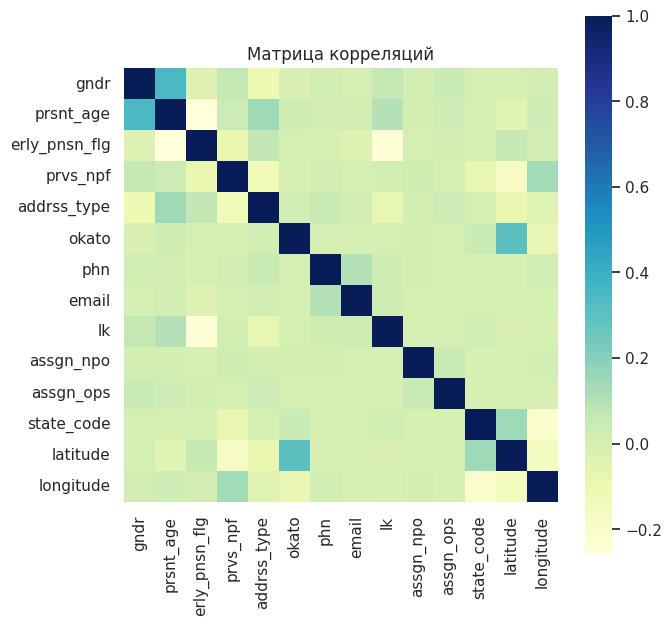

In [233]:
plt.figure(figsize=(7,7))
sns.heatmap(data = df_cold_start.corr(), annot=False, square=True, cmap='YlGnBu')
plt.title('Матрица корреляций')
plt.show()

In [235]:
# Разделение данных на признаки и целевую переменную
X = df_cold_start.drop(columns=['erly_pnsn_flg'])
y = df_cold_start['erly_pnsn_flg']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (419013, 13)
Test shape:  (104754, 13)


In [236]:
# Обучение модели бустинга
model = CatBoostClassifier(verbose=50, iterations=100, random_state=42)
model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.3518921	total: 65.1ms	remaining: 6.45s
50:	learn: 0.0614819	total: 1.61s	remaining: 1.55s
99:	learn: 0.0586632	total: 3.09s	remaining: 0us


In [237]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    100950
           1       0.88      0.55      0.68      3804

    accuracy                           0.98    104754
   macro avg       0.93      0.77      0.83    104754
weighted avg       0.98      0.98      0.98    104754



In [238]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

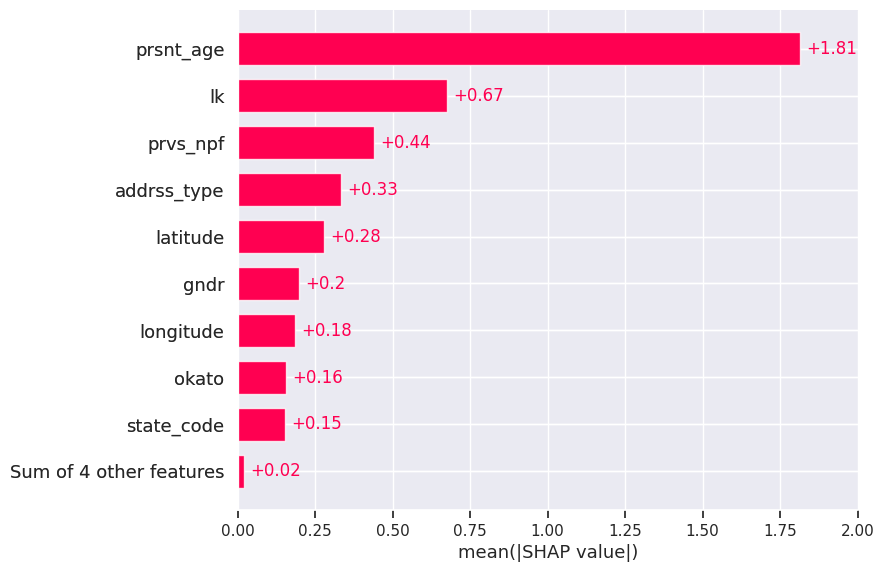

In [239]:
shap.plots.bar(shap_values)

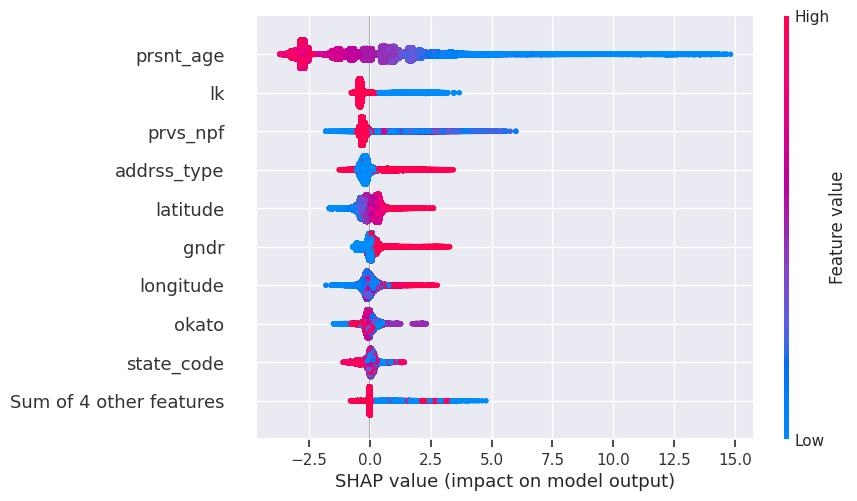

In [240]:
shap.plots.beeswarm(shap_values)

# Base flow

In [519]:
def agg_by_cluster(end_year):
    df_tr = df_trn[df_trn['oprtn_date'] <= end_year]
    
    agg_transactions = df_tr.groupby('accnt_id').agg({
        'mvmnt_type': 'mean',
        'sum_type': ['count', 'min', 'max', 'mean'],
        'sum': ['sum', 'max', 'min', 'mean']
    })
    agg_transactions.columns = ['_'.join(col).strip() for col in agg_transactions.columns.values]
    print('Shape: ', df_tr.shape)
    return agg_transactions

## All data

In [542]:
START_YEAR = '2020-01-01'
END_YEAR = '2021-01-01'

In [543]:
agg_trn = agg_by_cluster(START_YEAR)
merged_df = pd.merge(df_cnt, agg_trn, on='accnt_id', how='left')
merged_df

Shape:  (15622199, 7)


,slctn_nmbr,gndr,brth_yr,prsnt_age,accnt_bgn_date,cprtn_prd_d,erly_pnsn_flg,accnt_status,pnsn_age,prvs_npf,...,longitude,mvmnt_type_mean,sum_type_count,sum_type_min,sum_type_max,sum_type_mean,sum_sum,sum_max,sum_min,sum_mean
accnt_id,,,,,,,,,,,,,,,,,,,,,
0x00003A37F46E104EB1AB513510DC1C79,1,ж,1962,62,2011-02-25,397,0,Накопительный период,55,СФР,...,87.8000,0.000000,19.0,11.0,13.0,12.157895,2911.00,2096.31,-868.37,153.210526
0x00005C5B81A6B34C93DD254536771BB6,0,м,1959,65,2008-11-28,123,0,Накопительный период,60,СФР,...,33.0819,0.097561,41.0,11.0,13.0,12.219512,36472.70,9100.54,-5925.36,889.578049
0x000068BD0A374844BBD3F76E903BF0EE,0,ж,1962,62,2011-10-28,152,0,Накопительный период,55,СФР,...,102.2481,0.000000,20.0,11.0,13.0,12.100000,555.48,454.66,-454.66,27.774000
0x0000DEB99BDBE74D8298A7772971F4E5,0,м,1956,68,2006-12-26,87,0,Накопительный период,60,СФР,...,49.1333,0.000000,35.0,11.0,13.0,12.142857,1922.68,1417.26,-1417.26,54.933714
0x0000E3BFC6067F40844C2776DC44C5D9,0,ж,1963,61,2012-08-24,214,0,Накопительный период,55,СФР,...,61.4297,0.000000,11.0,11.0,13.0,11.909091,1906.39,779.68,0.00,173.308182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xFFFF62444E711C46A1F960FCFF343C6C,0,ж,1957,67,2010-11-02,140,0,Накопительный период,55,СФР,...,38.5203,0.000000,7.0,11.0,13.0,12.714286,4825.60,4802.16,0.00,689.371429
0xFFFF963DF681954095E4497060A5FB49,0,ж,1964,60,2010-10-25,140,0,Накопительный период,55,СФР,...,47.2303,0.000000,18.0,11.0,13.0,12.555556,0.00,0.00,0.00,0.000000
0xFFFFFCA6FFA8F54C96D02BB60C0BDBAE,1,ж,1964,60,2013-03-20,121,0,Накопительный период,55,СФР,...,99.1890,0.000000,13.0,11.0,13.0,11.615385,5161.93,2220.85,-639.30,397.071538


In [544]:
merged_df = merged_df[merged_df['first_pens_date'] >= pd.Timestamp(START_YEAR)]

merged_df['target'] = 0
filter_target = (merged_df['first_pens_date'] >= pd.Timestamp(START_YEAR)) & (merged_df['first_pens_date'] <= pd.Timestamp(END_YEAR))
merged_df.loc[filter_target, 'target'] = 1
merged_df[['target']].describe().T

,count,mean,std,min,25%,50%,75%,max
target,8359.0,0.163058,0.36944,0.0,0.0,0.0,0.0,1.0


In [545]:
def data_prepare(mrg_df, startdate):
    mrg_df['prsnt_age'] = pd.Timestamp(START_YEAR).year - mrg_df['brth_yr']
    mrg_df = mrg_df.drop(columns=['off_pens_date', 'current_date', 'first_pens_date', 'accnt_status', 'cprtn_prd_d', 'brth_yr'])
    mrg_df['accnt_bgn_date'] = mrg_df['accnt_bgn_date'].astype(int) // 10**11
    
    # Кодирование категориальных признаков
    ordinal_encoders = {}
    for column in mrg_df.select_dtypes(include=['object']).columns:
        oe = OrdinalEncoder(encoded_missing_value=-1)
        mrg_df[column] = mrg_df[column].astype(str)
        mrg_df[column] = oe.fit_transform(mrg_df[[column]])
        ordinal_encoders[column] = oe
    mrg_df = mrg_df.fillna(0)
    return mrg_df

In [546]:
merged_df = data_prepare(merged_df, START_YEAR)

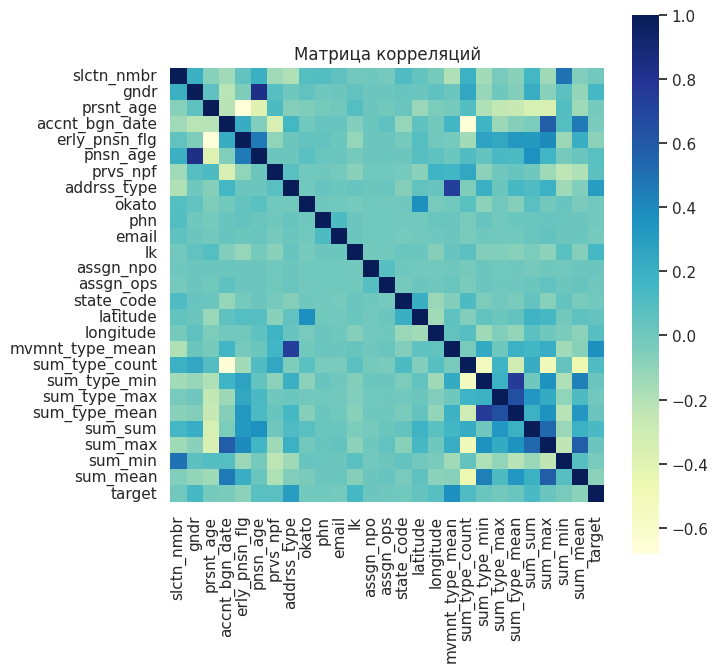

In [547]:
plt.figure(figsize=(7,7))
sns.heatmap(data = merged_df.corr(), annot=False, square=True, cmap='YlGnBu')
plt.title('Матрица корреляций')
plt.show()

In [548]:
# Разделение данных на признаки и целевую переменную
X = merged_df.drop(columns=['erly_pnsn_flg', 'target'])
y = merged_df['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (6687, 25)
Test shape:  (1672, 25)


In [549]:
# Обучение модели бустинга
model = CatBoostClassifier(verbose=50, iterations=500, random_state=42)
model.fit(X_train, y_train)

Learning rate set to 0.043788
0:	learn: 0.6563509	total: 5.09ms	remaining: 2.54s
50:	learn: 0.2816861	total: 248ms	remaining: 2.18s
100:	learn: 0.2473450	total: 491ms	remaining: 1.94s
150:	learn: 0.2268454	total: 731ms	remaining: 1.69s
200:	learn: 0.2104424	total: 972ms	remaining: 1.45s
250:	learn: 0.1961958	total: 1.21s	remaining: 1.2s
300:	learn: 0.1843583	total: 1.45s	remaining: 957ms
350:	learn: 0.1726444	total: 1.68s	remaining: 714ms
400:	learn: 0.1634146	total: 1.92s	remaining: 473ms
450:	learn: 0.1551075	total: 2.16s	remaining: 235ms
499:	learn: 0.1477177	total: 2.39s	remaining: 0us


In [550]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1399
           1       0.82      0.58      0.68       273

    accuracy                           0.91      1672
   macro avg       0.87      0.78      0.81      1672
weighted avg       0.91      0.91      0.90      1672



In [551]:
# Предсказание и оценка модели
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1: {f1_score_test}')

Accuracy: 0.9102870813397129
F1: 0.6781115879828327


In [552]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

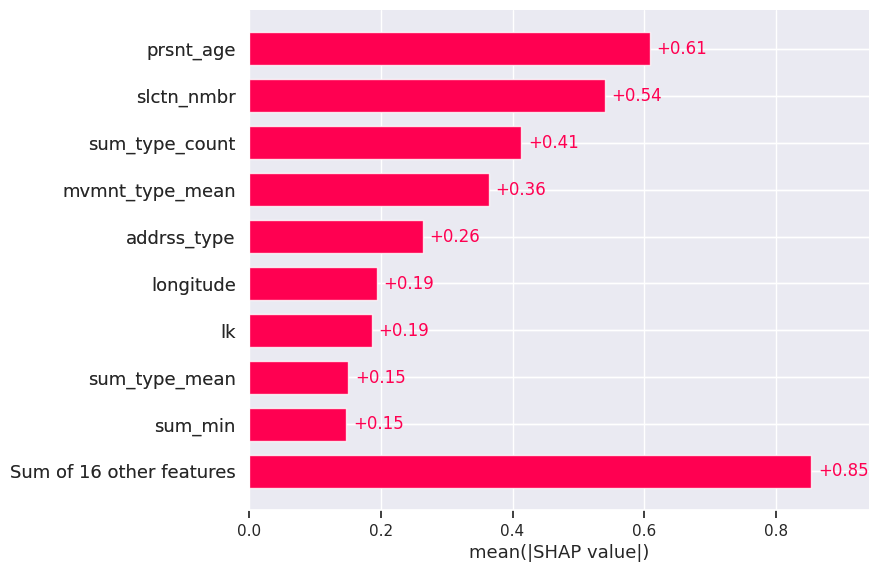

In [553]:
shap.plots.bar(shap_values)

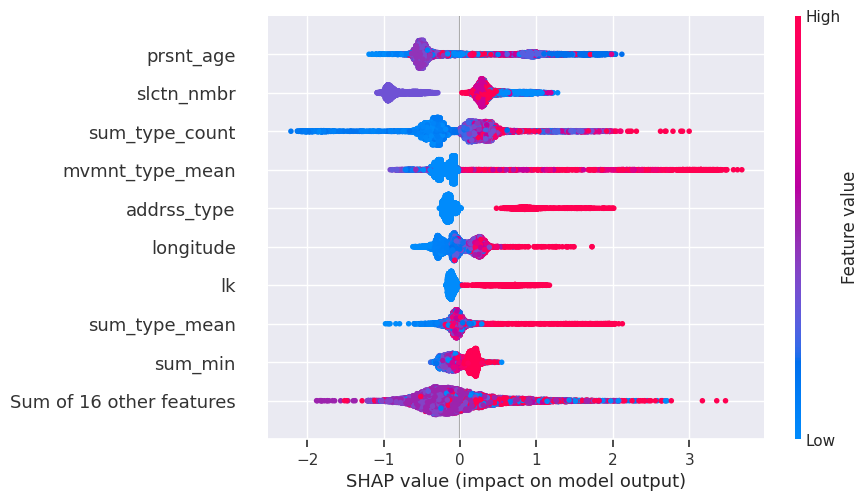

In [554]:
shap.plots.beeswarm(shap_values)

# Total learn

In [434]:
START_YEAR = '2021-01-01'
END_YEAR = '2022-01-01'

In [438]:
def calculate(start_year, end_year, model):
    agg_trn = agg_by_cluster(start_year)
    merged_df = pd.merge(df_cnt, agg_trn, on='accnt_id', how='left')
    
    merged_df = merged_df[merged_df['first_pens_date'] >= pd.Timestamp(start_year)]

    merged_df['target'] = 0
    filter_target = (merged_df['first_pens_date'] >= pd.Timestamp(start_year)) & (merged_df['first_pens_date'] <= pd.Timestamp(end_year))
    merged_df.loc[filter_target, 'target'] = 1
    
    merged_df = data_prepare(merged_df, start_year)
    
    # Разделение данных на признаки и целевую переменную
    X = merged_df.drop(columns=['erly_pnsn_flg', 'target'])
    y = merged_df['target']

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#     model = CatBoostClassifier(verbose=50, iterations=500, depth=8, learning_rate=0.1, random_state=42, auto_class_weights='Balanced')
    model = CatBoostClassifier(verbose=50, random_state=42, auto_class_weights='Balanced')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_test = f1_score(y_test, y_pred)
    
    return accuracy, f1_score_test, sum(y_test)

In [442]:
model_cl = CatBoostClassifier(verbose=50, iterations=200, depth=8, learning_rate=0.1, random_state=42)
START_YEARS = [f'{y}-01-01' for y in range(2015, 2024)]
END_YEARS = [f'{y}-01-01' for y in range(2016, 2025)]

In [445]:
acc_list = []
f1_score_list = []
y_sum = []

for i in range(len(START_YEARS)):
    y_start = START_YEARS[i]
    y_end = END_YEARS[i]
    print(f'Start year = {y_start}')
    acc, f1, target_sum = calculate(y_start, y_end, model_cl)
    acc_list.append(acc)
    f1_score_list.append(f1)
    y_sum.append(target_sum)

Start year = 2015-01-01
Shape:  (13209454, 13)
Learning rate set to 0.053945
0:	learn: 0.6113488	total: 11.7ms	remaining: 11.7s
50:	learn: 0.1393885	total: 602ms	remaining: 11.2s
100:	learn: 0.1160878	total: 1.2s	remaining: 10.7s
150:	learn: 0.1038406	total: 1.79s	remaining: 10.1s
200:	learn: 0.0945714	total: 2.45s	remaining: 9.72s
250:	learn: 0.0867395	total: 3.06s	remaining: 9.13s
300:	learn: 0.0803670	total: 3.67s	remaining: 8.52s
350:	learn: 0.0757968	total: 4.27s	remaining: 7.89s
400:	learn: 0.0723261	total: 4.86s	remaining: 7.26s
450:	learn: 0.0689972	total: 5.45s	remaining: 6.64s
500:	learn: 0.0661954	total: 6.05s	remaining: 6.02s
550:	learn: 0.0632168	total: 6.66s	remaining: 5.43s
600:	learn: 0.0612282	total: 7.25s	remaining: 4.82s
650:	learn: 0.0592733	total: 7.85s	remaining: 4.21s
700:	learn: 0.0577153	total: 8.45s	remaining: 3.6s
750:	learn: 0.0562862	total: 9.04s	remaining: 3s
800:	learn: 0.0550677	total: 9.61s	remaining: 2.39s
850:	learn: 0.0536969	total: 10.2s	remaining: 

In [451]:
f1_score_list

[0.980753009738517,
 0.8879194630872483,
 0.7984224364592463,
 0.7400228050171037,
 0.6693069306930693,
 0.5983739837398374,
 0.5628517823639775,
 0.6185567010309277,
 0.6889312977099236]

In [ ]:
g = sns.lineplot(f1_score_list)
g.set_xticklabels(START_YEARS, rotation=30)
g.set_xlabel('Год исследования')
g.set_ylabel('F1 score')
g.set_title('Значение F1 по годам')

# Answer

In [ ]:
df_ans = pd.read_csv('/kaggle/input/ai-hack-pfo/train_data/sample_submission.csv')
df_ans.head()